In [1]:
import os
import pandas as pd
import collections
import pickle
#import cPickle
import _pickle as cPickle

import scipy
from scipy import sparse
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec, CoherenceModel
from gensim.summarization import summarize
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics
import time

import bokeh

In [2]:
# Configurations and Variable Definitions

In [3]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
DATA_FILE = DATA_FILE = '/data/pubmed_result_6517_0900_"Pain"[Mesh]_Medline_EnglishOnlyFilter.txt'
#test variables
# test_pmid = '27179337'
test_pmid = '28324318'

In [4]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

In [5]:
# Input File Processing

In [6]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
#Note that this differs from above by removing grants and affiliations in an effort to minimize exceptions
def read_medline_data_raw(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "abstract"])
    count = 0
    for rec in recs:
        try:
            pmid = rec['PMID']
            atitle = rec["TI"]
            jtitle = rec["JT"]
            pubdate = rec["DP"]
            abstr = rec["AB"]
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle,pubdate, abstr]],
                columns=["pmid", "articletitle", "journaltitle", "pubdate", "abstract"]),ignore_index=True, verify_integrity=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [7]:
# get the Data file path

print("Cell started at: " + time.strftime("%c"))
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data_raw(DATA_PATH)
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')
papers.to_csv('data/papers_pain_EngFilter_6_5_2017_raw_oct17update.csv')
print("Cell completed at: " + time.strftime("%c"))

Cell started at: Sun Jun  3 22:43:36 2018
CPU times: user 1h 16min 51s, sys: 9min 21s, total: 1h 26min 12s
Wall time: 1h 26min 12s
Cell completed at: Mon Jun  4 00:10:09 2018


In [8]:
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')

In [9]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202053 entries, 0 to 202052
Data columns (total 5 columns):
abstract        202053 non-null object
articletitle    202053 non-null object
journaltitle    202053 non-null object
pmid            202053 non-null object
pubdate         202053 non-null object
dtypes: object(5)
memory usage: 7.7+ MB


In [10]:
pubdatevalues = papers.pubdate.unique()
#pubdatevalues.tofile("pubdatevalues.csv", sep=',') Examine range of pubdates manually in csv

In [11]:
papers['pubdate_dtformat'] = pd.to_datetime(papers.pubdate, format='%Y', exact=False)
papers['pubyear'] = pd.DatetimeIndex(papers['pubdate_dtformat']).year
papers=papers.drop('pubdate_dtformat', axis=1)

In [12]:
papers.tail(10)

abstract  \
202043  AIMS: To conduct a systematic review to determ...   
202044  AIMS: To assess the influence of clenching sid...   
202045  AIMS: To determine if pressure pain thresholds...   
202046  AIMS: To evaluate the transient effects of ort...   
202047  AIMS: To analyze the methodologic quality, sum...   
202048  AIMS: To investigate the relationship between ...   
202049  AIMS: To evaluate whether a biobehavioral inte...   
202050  We propose that trigger-point dry needle (TrP-...   
202051  Erythrocytosis, or increased red blood cell ma...   
202052  PURPOSE: Juvenile idiopathic arthritis (JIA) i...   

                                             articletitle  \
202043  Systematic Review and Meta-analysis of the Eff...   
202044  Ipsilateral Molar Clenching Induces Less Pain ...   
202045  The Effects of Mandibular Advancement Device o...   
202046  Transient Pain Following Orthodontic Fixed App...   
202047  The Effectiveness of Physiotherapy in the Mana...   
202048  Circulating Omentin-1 and Chronic Painful Temp...   
202049  Temporomandibular Disorder Diagnostic Groups A...   
202050      Trigger-Point Dry Needling for the SOF Medic.   
202051  Secondary Hypertension, Erythrocytosis, and Un...   
202052  The Effects of Orthopedic Manual Physical Ther...   

                                             journaltitle      pmid  \
202043         Journal of oral & facial pain and headache  27472529   
202044         Journal of oral & facial pain and headache  27472527   
202045         Journal of oral & facial pain and headache  27472526   
202046         Journal of oral & facial pain and headache  27472525   
202047         Journal of oral & facial pain and headache  27472523   
202048         Journal of oral & facial pain and headache  27472522   
202049         Journal of oral & facial pain and headache  27472521   
202050  Journal of special operations medicine : a pee...  28088815   
202051  Journal of special operations medicine : a pee...  28088811   
202052  Pediatric physical therapy : the official publ...  27661250   

            pubdate  pubyear  
202043  Summer 2016     2016  
202044  Summer 2016     2016  
202045  Summer 2016     2016  
202046  Summer 2016     2016  
202047  Summer 2016     2016  
202048  Summer 2016     2016  
202049  Summer 2016     2016  
202050  Winter 2016     2016  
202051  Winter 2016     2016  
202052  Winter 2016     2016

In [13]:
papers.loc[papers['pubdate']=='2011 Nov']

abstract  \
54329  BACKGROUND: Addiction is a feared complication...   
54332  AIM: Prevalence rates for deliberate self-harm...   
54333  AIM: To establish to what extent somatic cause...   
54334  AIM: First, to what extent do general paediatr...   
54335  AIM: To compare the efficacy of sublingual mid...   
54337  INTRODUCTION: D-Dimer (DD) has been described ...   
54338  BACKGROUND: Many analgesic modalities have bee...   
54344  OBJECTIVE: The purpose of this article is to s...   
54348  BACKGROUND: Myeloperoxidase (MPO) is proposed ...   
54350  UNLABELLED: Patients frequent take acetaminoph...   
54351  BACKGROUND: Brief and efficacious intervention...   
54352  INTRODUCTION: Much less is known about pain pr...   
54353  STUDY OBJECTIVE: The aims of the study were to...   
54355  Diarrhea is one of the commonest complication ...   
54356  BACKGROUND: Older adults (OA) with advanced ca...   
54357  Acute appendicitis presents typically with per...   
54358  Obstetrician/gynecologists often are the initi...   
54363  BACKGROUND: While few comparative studies exis...   
54364  BACKGROUND: Reports of return to shoulder-depe...   
54365  BACKGROUND: An avulsion fracture of the proxim...   
54366  BACKGROUND: In patients with lateral epicondyl...   
54367  BACKGROUND: There has been increasing attentio...   
54368  BACKGROUND: The prognosis of patients with col...   
54369  Cryptogenic multifocal ulcerous stenosing ente...   
54370  Fibromyalgia (FM) is a mysterious pain syndrom...   
54371  Pancreatic duct stone is thought not only to b...   
54372  A volunteer study suggested that taking parace...   
54373  The classic definition of preemptive analgesia...   
54374  BACKGROUND: Postoperative pain can delay funct...   
54375  BACKGROUND: Radiofrequency facet denervation i...   
...                                                  ...   
54950  PURPOSE: Phantom pain in upper limb amputees i...   
54951  Ramadan fasting for Muslims means abstinence f...   
54952  OBJECTIVE: In this study we compared activity ...   
54953  OBJECTIVE: This paper investigates secondary o...   
54954  Intravenous cannulation is a commonly performe...   
54955  OBJECTIVE: Glomus coccygeum is a glomus body w...   
54956  Lateral ankle pain is a common clinical presen...   
54961  Commentary on: Berg S, Tropp HT, Leivseth G. D...   
54962  BACKGROUND CONTEXT: Fusion is considered the "...   
54963  Stress regulation during pregnancy is consider...   
54964  PURPOSE: Good cancer pain control requires app...   
54965  BACKGROUND: Pain following laparoscopic cholec...   
54966  BACKGROUND: Posterior retroperitoneoscopic adr...   
54967  PURPOSE: Lichtenstein repair has been the gold...   
54968  PURPOSE: The Estimation of Physiologic Ability...   
54969  BACKGROUND: Little is known about the longer t...   
54970  Resolvins, including D and E series resolvins,...   
54974  An abdominal cocoon is an extremely rare condi...   
54975  BACKGROUND: Nitroglycerine (NTG) has analgesic...   
54977  OBJECTIVES: To examine changes in the associat...   
54978  We present a case of combined celiac axis and ...   
54979  Renal vein compression syndromes are rare caus...   
54980  OBJECTIVE: Comparison of the analgesic effect ...   
54981  Thirty-one dogs were randomised to receive int...   
54982  The objective of this study was to develop a s...   
54983  OBJECTIVE: To evaluate the effectiveness of to...   
54985  BACKGROUND: The goal of the present research w...   
54986  BACKGROUND: Recurrent spontaneous pneumothorax...   
54987  PURPOSE: We investigated what kinds of neurotr...   
54988  PURPOSE: Lipoprotein-associated phospholipase ...   

                                            articletitle  \
54329  Validation and usefulness of the Danish versio...   
54332     Deliberate self-harm by Taiwanese adolescents.   
54333  Recurrent abdominal pain in 200 children: soma...   
54334  Paediatric functional abdominal pain: signific...   
54335  Comparison of a morp

In [6]:
papers.journaltitle.nunique()

5333

In [5]:
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')

In [16]:
# Text Cleanup & Tokenization

In [17]:
## Remove "all-caps:" section headers, punctuation marks, numbers, and option for words in all capital letters

In [18]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    
    return abstracts, non_digit_filtered

In [19]:
## Remove stop words

In [20]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = str.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

In [21]:
## Convert to lower case, tokenize

In [22]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [23]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

In [24]:
## Combine Preprocess Functions

In [25]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [26]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    return abstracts

In [27]:
## Apply preprocessing

In [28]:
#import nltk
#nltk.download('stopwords')

In [29]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
%time papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

CPU times: user 17.3 s, sys: 1.73 s, total: 19.1 s
Wall time: 19.1 s


In [30]:
#Show list of filtered terms
print(filtered)

['', 'CARDS', 'TBI', 'WP', 'SUI', ' PURPOSE OF', 'DPTI', 'BPI', 'RT', 'CHANCE', ' ONSET', 'PARTICIPATIONS', ' DESIGN, SETTING, PATIENTS AND', ' CLINCIAL', ' DESIGN SETTINGS AND', 'RAP', 'LITERATURE REVIEW AND CASE', 'IMPLICATIONS FOR', 'PSC', 'INCIDENCE', ' LIMITATIONS AND REASONS FOR', 'NAC', 'OUTCOME', ' PATIENTS AND', ' STATEMENT OF CONCLUSIONS AND RECOMMENDATIONS FOR PHYSICAL THERAPY', 'SUBJECTS', ' NEW', ' INTERVENTION AND OUTCOME', 'MEDICINE', ' RATE', 'DIAGNOSIS', ' MEASUREMENT AND', ' SAMPLES AND', ' INDICATIONS FOR', ' KEY MEASURE FOR', 'FRAMEWORK', 'DEFINITION', 'SP', 'VATS', ' LINKED', 'STATEMENT OF THE', 'ST', ' SETTING AND SAMPLE', 'SDH', ' CX,', 'SUMMARY OF BACKGROUND DATA AND', 'MEDICATIONS', 'BACKGROUND AND AIM OF', 'TOXICITY', 'LCA', 'CONCERNS', 'SCORING', 'PURPOSE', 'INTEPRETATION', 'NE', ' AIM OF THE', ' PATHOPHYSIOLOGICAL', 'MSM', 'DIRECTIONS', ' DURING', ' DESIGN,', 'NTBI', 'YAG', 'ASV', 'OXY', 'BUN', 'SRD', ' CHOOSING COMPUTER', 'SIJ', 'GROUP', 'INCREASE', ' AREA 

In [5]:
#papers.to_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')
%time papers = pd.read_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')

CPU times: user 13.4 s, sys: 3.88 s, total: 17.3 s
Wall time: 17.3 s


In [6]:
papers

abstract  \
0       pH-sensitive nonionic surfactant vesicles (nio...   
1       BACKGROUND: The prevalence of migraine with co...   
2       BACKGROUND: Identification of subgroups of pat...   
3       BACKGROUND: Burning Mouth Syndrome (BMS) is a ...   
4       BACKGROUND: Despite their huge epidemiological...   
5       BACKGROUND: Calcitonin gene-related peptide (C...   
6       BACKGROUND: The aim of this study was to inves...   
7       BACKGROUND: Cardiac cephalalgia (CC) is a rare...   
8       BACKGROUND: In the emergency setting, non-trau...   
9       BACKGROUND: A better understanding of potentia...   
10      BACKGROUND: Frequent mild head injuries or con...   
11      BACKGROUND: We investigated the prevalence of ...   
12      BACKGROUND: Hyperbaric oxygen (HBO) therapy is...   
13      CONTEXT: (-)-alpha-Bisabolol (BISA) is a sesqu...   
14      CONTEXT: Pterocephalus hookeri (C. B. Clarke) ...   
15      CONTEXT: The leaves of Albizia zygia (DC.) J.F...   
16      CONTEXT: Linalool oxide (OXL) (a monoterpene) ...   
17      Infective spondylodiscitis is a rare disease. ...   
18      BACKGROUND: The prognostic role of hypertensio...   
19      BACKGROUND: Western Pygmy Rattlesnake (WPR) en...   
20      Chronic neuropathic pain is a complicated cond...   
21      The study aimed to evaluate the effect of Zing...   
22      Background: The HEART (History, Electrocardiog...   
23      Background: High-sensitivity assays for cardia...   
24      A literature review identified six placebo-con...   
25      BACKGROUND: Coronary revascularization guided ...   
26      BACKGROUND: The instantaneous wave-free ratio ...   
27      OBJECTIVE: A majority of patients with advance...   
28      BACKGROUND: The pathophysiology of functional ...   
29      BACKGROUND: The diagnosis of gastro-oesophagea...   
...                                                   ...   
202023  Spinal anesthesia is an essentially safe proce...   
202024  Banthine(R) was used in the treatment of patie...   
202025  Menstruation, a physiologic function, should b...   
202026  The author report clinical experience with 212...   
202027  Experience with caudal analgesia for obstetric...   
202028  In fifteen cases of amebiasis masquerading as ...   
202029  The primary radiologic evidence of intra-abdom...   
202030  The most disabling form of Parkinsonism is tha...   
202031  In spite of widely dispersed modern knowledge ...   
202032  In a review of the records in 50 cases of ameb...   
202033  In over 400 treatments with procaine intraveno...   
202034  Chronic relapsing pancreatitis is a disease of...   
202035  The cause of endometriosis is not known. The i...   
202036  Although one-eighth to one-tenth of all fractu...   
202037  1. Frontal lobotomy is an effective procedure ...   
202038  The nature of tendinitis and bursitis of the s...   
202039  Fifty-four patients with various classificatio...   
202040  Neck and shoulder pains are presenting or inci...   
202041  Five hundred consecutive admissions to the rhe...   
202042  AIM: Rehabilitation of the edentulous atrophic...   
202043  AIMS: To conduct a systematic review to determ...   
202044  AIMS: To assess the influence of clenching sid...   
202045  AIMS: To determine if pressure pain thresholds...   
202046  AIMS: To evaluate the transient effects of ort...   
202047  AIMS: To analyze the methodologic quality, sum...   
202048  AIMS: To investigate the relationship between ...   
202049  AIMS: To evaluate whether a biobehavioral inte...   
202050  We propose that trigger-point dry needle (TrP-...   
202051  Erythrocytosis, or increased red blood cell ma...   
202052  PURPOSE: Juvenile idiopathic arthritis (JIA) i...   

                                             articletitle  \
0       pH-sensitive niosomes: Effects on cytotoxicity...   
1       Level of physical activity, well-being, stress...   
2       Identification of subgroups of patients with t...   
3       Refractory bur

In [7]:
#Test
print('Original Abstract: \n', papers.abstract[papers.pmid == test_pmid])
print('\nCleaned Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL])
print('\nTokenized Abstract: \n', papers.loc[papers.pmid == test_pmid, TOKENIZED_CLEAN_ABS_COL])
print('\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL])
papers[(papers.pmid == test_pmid)]

Original Abstract: 
 4    BACKGROUND: Despite their huge epidemiological...
Name: abstract, dtype: object

Cleaned Abstract: 
 4    despite huge epidemiological impact primary he...
Name: cleaned_abstract, dtype: object

Tokenized Abstract: 
 4    [despite, huge, epidemiological, impact, prima...
Name: tokenized_c_abstract, dtype: object

Minimally Processed Abstract: 
 4    BACKGROUND#NUM Despite their huge epidemiologi...
Name: cleaned_minimal_abstract, dtype: object


abstract  \
4  BACKGROUND: Despite their huge epidemiological...   

                                        articletitle  \
4  Botulinum neurotoxin type A for the treatment ...   

                       journaltitle      pmid   pubdate  pubyear  \
4  The journal of headache and pain  28324318  2017 Dec     2017   

                                    cleaned_abstract  \
4  despite huge epidemiological impact primary he...   

                                tokenized_c_abstract  \
4  [despite, huge, epidemiological, impact, prima...   

                            cleaned_minimal_abstract  \
4  BACKGROUND#NUM Despite their huge epidemiologi...   

                                tokenized_r_abstract  token_count_c_abstract  \
4  [BACKGROUND, Despite, their, huge, epidemiolog...                     113   

   token_count_r_abstract  token_count_unq_c_abstract  
4                     168                          85

In [8]:
# Topic Modeling with LDA

In [9]:
## Create Corpus, Dictionary, and Related Text Constructs

In [10]:
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [11]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [12]:
## Topic Modeling via LDA

In [13]:
### Determine optimal number of topics through coherence testing

In [14]:
dtm_path = '/home/bharadwaj/dtm-master/dtm/main'
os.path.isfile(dtm_path)

True

In [15]:
#time_seq=pd.Series.tolist(papers["pubyear"])
#time_seq = [3, 58]  # first 3 documents are from time slice one 
corpus=ca_gs_corpus

In [16]:
years=papers.pubyear.tolist()
#years
l=np.array(years)
a=np.bincount(l)
time_seq1=a.tolist()
print(np.sum(a))
time_seq=a[np.nonzero(a)].tolist()
time_seq

202053


[3,
 9,
 5,
 4,
 5,
 5,
 7,
 4,
 6,
 9,
 8,
 9,
 6,
 12,
 19,
 16,
 9,
 12,
 5,
 17,
 29,
 44,
 44,
 36,
 44,
 59,
 828,
 776,
 790,
 793,
 884,
 991,
 1021,
 1181,
 1567,
 1753,
 2020,
 2109,
 1997,
 2093,
 2542,
 2593,
 2987,
 2973,
 3124,
 3424,
 3514,
 3830,
 4136,
 4454,
 4750,
 5165,
 5466,
 5742,
 6363,
 7113,
 7599,
 7677,
 8399,
 8750,
 9126,
 9741,
 9877,
 10738,
 10903,
 11337,
 11837,
 7509,
 1155]

In [17]:
min(years)

1949

In [18]:
model = DtmModel(dtm_path, corpus, time_seq, num_topics=1,
                 id2word=ca_gs_dictionary, initialize_lda=True)

In [19]:
topics = model.show_topic(topicid=0, time=30, num_words=10)
topics

/home/bharadwaj/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


[(0.025038728299436867, 'pain'),
 (0.014800542324179893, 'patients'),
 (0.006609706620999953, 'study'),
 (0.005664392766575617, 'group'),
 (0.0048905636780630065, 'treatment'),
 (0.0034615945818212072, 'chronic'),
 (0.003241803042723872, 'clinical'),
 (0.003039278459732552, 'patient'),
 (0.0030085848063008095, 'associated'),
 (0.0029457648018230576, 'compared')]

In [20]:
print("Hey I just worked")

Hey I just worked


In [21]:
model.save('DTMPUBMEDsingletopic', separately=None, sep_limit=10485760, ignore=frozenset([]))

In [67]:
model2=DtmModel.load('DTMPUBMEDsingletopic',mmap=None)

In [68]:
topics = model2.show_topic(topicid=0, time=40, num_words=200)
topics

/home/bharadwaj/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning:

The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.



[(0.026725666397245787, 'pain'),
 (0.014993744345282648, 'patients'),
 (0.006593992253601261, 'study'),
 (0.00581529912868289, 'group'),
 (0.005094677520467711, 'treatment'),
 (0.0036687014685314575, 'chronic'),
 (0.0033677702462331436, 'clinical'),
 (0.0031057398224782354, 'patient'),
 (0.003079228664155744, 'significant'),
 (0.0030181744604889198, 'associated'),
 (0.0029914255256887246, 'using'),
 (0.0028417301568075147, 'significantly'),
 (0.00278845255745987, 'compared'),
 (0.0027709271047605625, 'may'),
 (0.0026100864666163226, 'used'),
 (0.0025422001058753555, 'groups'),
 (0.002454949124634809, 'surgery'),
 (0.002433327786874534, 'symptoms'),
 (0.002416342513357322, 'studies'),
 (0.0023888681413260907, 'years'),
 (0.00235757879300796, 'use'),
 (0.0023564177561191018, 'reported'),
 (0.002277559004600194, 'effects'),
 (0.002214606384631748, 'two'),
 (0.002204505382858821, 'related'),
 (0.0021950357375672344, 'data'),
 (0.0021608422988418875, 'low'),
 (0.0021601367237604314, 'time')

In [50]:
k=model.show_topics(num_topics=-1,times=68,log=False, formatted=False,num_words=300)

/home/bharadwaj/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


In [51]:
k

[[(0.017007533761076603, 'pain'),
  (0.012490082636086718, 'patients'),
  (0.004576356655528289, 'study'),
  (0.004112659829061773, 'group'),
  (0.003643105945560808, 'treatment'),
  (0.0024346274280393904, 'clinical'),
  (0.0023868881632644902, 'patient'),
  (0.0023585772193919553, 'compared'),
  (0.002319637997800425, 'chronic'),
  (0.0021321702007955335, 'significant'),
  (0.002125409147607023, 'associated'),
  (0.002033684412920033, 'significantly'),
  (0.0020287711121525324, 'using'),
  (0.0019563455312416383, 'mean'),
  (0.001933244149774209, 'effects'),
  (0.0019179417552909318, 'surgery'),
  (0.0019084280755857, 'may'),
  (0.0018974303015151317, 'groups'),
  (0.001865134352571017, 'years'),
  (0.0018525955196519153, 'scores'),
  (0.0018365312486872546, 'studies'),
  (0.0017678013595236613, 'used'),
  (0.0017412356081796048, 'quality'),
  (0.001727558874322045, 'symptoms'),
  (0.001710043089873045, 'headache'),
  (0.001694380933398595, 'outcomes'),
  (0.001693624207301405, 'post

In [52]:
d=dict()
for i in range(0,len(k),1):
    for m, n in k[i]:
            d[n]=[]

In [53]:
d

{'abdominal': [],
 'action': [],
 'activation': [],
 'activity': [],
 'acute': [],
 'addition': [],
 'administered': [],
 'administration': [],
 'adults': [],
 'adverse': [],
 'age': [],
 'aim': [],
 'also': [],
 'although': [],
 'among': [],
 'analgesia': [],
 'analgesic': [],
 'analyses': [],
 'analysis': [],
 'anesthesia': [],
 'angina': [],
 'anterior': [],
 'anti': [],
 'anxiety': [],
 'approach': [],
 'area': [],
 'arterial': [],
 'artery': [],
 'assess': [],
 'assessed': [],
 'assessment': [],
 'associated': [],
 'association': [],
 'average': [],
 'back': [],
 'based': [],
 'baseline': [],
 'beta': [],
 'better': [],
 'blind': [],
 'block': [],
 'blood': [],
 'body': [],
 'bone': [],
 'bupivacaine': [],
 'bypass': [],
 'cancer': [],
 'cardiac': [],
 'care': [],
 'case': [],
 'cases': [],
 'cause': [],
 'cci': [],
 'cent': [],
 'central': [],
 'change': [],
 'changes': [],
 'characteristics': [],
 'chest': [],
 'children': [],
 'chronic': [],
 'ci': [],
 'clbp': [],
 'clinical':

In [55]:
for i in range(0,len(k),1):
    for n in d:
        for p,q in k[i]:
            if n==q:
                d[n].append(p)    
        if all(n!=q for p,q in k[i]):
                d[n].append(0)

In [56]:
len(d['pain'])

68

In [57]:
y=list(range(min(years),max(years)))
max(years)

2017

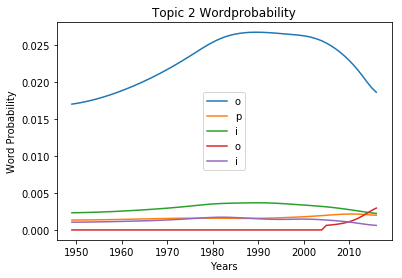

In [61]:
#plt.plot(y,d['pain'])
#plt.legend('pain')
plt.plot(y,d['acute'])
plt.legend('acute')
plt.plot(y,d['chronic'])
plt.legend('chronic')
plt.plot(y,d['myocardial'])
plt.legend('myocardial')
plt.plot(y,d['opioid'])
plt.legend('opioid')
#plt.plot(y,d['myocardial'])
#plt.legend('myocardial')
plt.xlabel('Years')
plt.ylabel('Word Probability')
plt.title('Topic 2 Wordprobability')
plt.show()

In [650]:
model=DtmModel.load('DTMPUBMED',mmap=None)

In [65]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode()
trace1 = go.Scatter(
    x = y,
    y = d['pain'],
    #mode = 'lines+markers',
    name = 'pain'
)
trace2 = go.Scatter(
    x = y,
    y = d['acute'],
    #mode = 'lines+markers',
    name = 'acute'
)
trace3 = go.Scatter(
    x = y,
    y = d['chronic'],
    #mode = 'lines+markers',
    name = 'chronic'
)
trace4 = go.Scatter(
    x = y,
    y = d['myocardial'],
    #mode = 'lines+markers',
    name = 'myocardial'
)
trace5 = go.Scatter(
    x = y,
    y = d['opioid'],
    #mode = 'lines+markers',
    name = 'opioid'
)
trace6 = go.Scatter(
    x = y,
    y = d['neuropathic'],
    #mode = 'lines+markers',
    name = 'neuropathic'
)
trace7 = go.Scatter(
    x = y,
    y = d['analgesic'],
    #mode = 'lines+markers',
    name = 'analgesic'
)

data = [trace2, trace3,trace4,trace5,trace6,trace7]
layout = dict(title = 'Word Probabilities',
              xaxis = dict(title = 'Years'),
              yaxis = dict(title = 'Word Probabilities'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Pyplot-Topic_2')